In [1]:
import torch

In [2]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('Bummer!  Training on CPU ...')
else:
    print('You are good to go!  Training on GPU ...')

You are good to go!  Training on GPU ...


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#Run this cell to download the Udacity flower set
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!unzip -qq flower_data.zip

In [6]:
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/cat_to_name.json # Download cat_to_name.json

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
import os

from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

In [8]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [9]:
train_data_transforms = transforms.Compose ([transforms.RandomRotation (30),
                                             transforms.RandomResizedCrop (224),
                                             transforms.RandomHorizontalFlip (),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

valid_data_transforms = transforms.Compose ([transforms.Resize (255),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])

test_data_transforms = transforms.Compose ([transforms.Resize (255),
                                             transforms.CenterCrop (224),
                                             transforms.ToTensor (),
                                             transforms.Normalize ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
                                            ])


# TODO: Load the datasets with ImageFolder
train_image_datasets = datasets.ImageFolder (train_dir, transform = train_data_transforms)
valid_image_datasets = datasets.ImageFolder (valid_dir, transform = valid_data_transforms)
test_image_datasets = datasets.ImageFolder (valid_dir, transform = test_data_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size = 64, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_image_datasets, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_image_datasets, batch_size = 64, shuffle = True)

In [11]:
# Label mapping
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [12]:
model_name = 'vgg' #@param ['densenet', 'vgg']
if model_name == 'densenet':
    model = models.vgg16(pretrained=True)
    num_in_features = 2208
    print(model)
elif model_name == 'vgg':
    model = models.vgg19(pretrained=True)
    num_in_features = 25088
    print(model.classifier)
else:
    print("Unknown model, please choose 'densenet' or 'vgg'")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 80.7MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


In [13]:
# updating classifer in the network
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential  (OrderedDict ([
                            ('fc1', nn.Linear (num_in_features, 4096)),
                            ('relu1', nn.ReLU ()),
                            ('dropout1', nn.Dropout (p = 0.3)),
                            ('fc2', nn.Linear (4096, 2048)),
                            ('relu2', nn.ReLU ()),
                            ('dropout2', nn.Dropout (p = 0.3)),
                            ('fc3', nn.Linear (2048, 1024)),
                            ('relu3', nn.ReLU ()),
                            ('dropout3', nn.Dropout (p = 0.3)),
                            ('fc4', nn.Linear (1024, 512)),
                            ('relu4', nn.ReLU ()),
                            ('dropout4', nn.Dropout (p = 0.3)),
                            ('fc5', nn.Linear (512, 102)),
                            ('output', nn.LogSoftmax (dim =1))
                            ]))
model.classifier = classifier
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
#initializing criterion and optimizer
criterion = nn.NLLLoss ()
optimizer = optim.Adam (model.classifier.parameters (), lr = 0.001)

In [15]:
# Defining validation
def validation(model, valid_loader, criterion):
    model.to ('cuda')

    valid_loss = 0
    accuracy = 0
    for inputs, labels in valid_loader:

        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        output = model.forward(inputs)
        valid_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss, accuracy

In [18]:
#training a model

#change to cuda if enabled
model.to ('cuda')
# Move optimizer state to GPU
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()
epochs = 10
print_every = 40
steps = 0


for e in range (epochs):
    running_loss = 0
    for ii, (inputs, labels) in enumerate (train_loader):
        steps += 1

        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad () #where optimizer is working on classifier paramters only

        # Forward and backward passes
        outputs = model.forward (inputs) #calculating output
        loss = criterion (outputs, labels) #calculating loss
        loss.backward ()
        optimizer.step () #performs single optimization step

        running_loss += loss.item () # loss.item () returns scalar value of Loss function

        if steps % print_every == 0:
            model.eval () #switching to evaluation mode so that dropout is turned off

            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                valid_loss, accuracy = validation(model, valid_loader, criterion)

            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Valid Loss: {:.3f}.. ".format(valid_loss/len(valid_loader)),
                  "Valid Accuracy: {:.3f}%".format(accuracy/len(valid_loader)*100))

            running_loss = 0

            # Make sure training is back on
            model.train()


Epoch: 1/10..  Training Loss: 3.802..  Valid Loss: 3.119..  Valid Accuracy: 21.952%
Epoch: 1/10..  Training Loss: 3.149..  Valid Loss: 2.374..  Valid Accuracy: 38.106%
Epoch: 2/10..  Training Loss: 1.191..  Valid Loss: 2.105..  Valid Accuracy: 41.178%
Epoch: 2/10..  Training Loss: 2.509..  Valid Loss: 1.921..  Valid Accuracy: 47.255%
Epoch: 2/10..  Training Loss: 2.360..  Valid Loss: 1.689..  Valid Accuracy: 52.851%
Epoch: 3/10..  Training Loss: 1.780..  Valid Loss: 1.451..  Valid Accuracy: 59.144%
Epoch: 3/10..  Training Loss: 2.067..  Valid Loss: 1.412..  Valid Accuracy: 61.000%
Epoch: 4/10..  Training Loss: 0.567..  Valid Loss: 1.372..  Valid Accuracy: 60.966%
Epoch: 4/10..  Training Loss: 1.843..  Valid Loss: 1.266..  Valid Accuracy: 65.962%
Epoch: 4/10..  Training Loss: 1.810..  Valid Loss: 1.165..  Valid Accuracy: 67.524%
Epoch: 5/10..  Training Loss: 1.173..  Valid Loss: 1.099..  Valid Accuracy: 67.591%
Epoch: 5/10..  Training Loss: 1.693..  Valid Loss: 1.025..  Valid Accuracy: 

In [19]:
# TODO: Do validation on the test set

ts_correct = 0
ts_total = 0

with torch.no_grad ():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model (inputs)
        _, predicted = torch.max (outputs.data,1)
        ts_total += labels.size (0)
        ts_correct += (predicted == labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (100 * ts_correct / ts_total))
ts_total

Accuracy of the network on test images: 72 %


818

In [20]:
model.to ('cpu') #no need to use cuda for saving/loading model.
# TODO: Save the checkpoint
model.class_to_idx = train_image_datasets.class_to_idx #saving mapping between predicted class and class name,
#second variable is a class name in numeric

#creating dictionary
checkpoint = {'classifier': model.classifier,
              'state_dict': model.state_dict (),
              'mapping':    model.class_to_idx
             }

torch.save (checkpoint, 'project_checkpoint.pth')
#you should also store other hyper-parameters like the number of epochs, the learning_rate, arch param
#along with the checkpoint. This parameters are required in case you need to continue training your model

In [21]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

def loading_model (file_path):
    checkpoint = torch.load (file_path) #loading checkpoint from a file
    model = models.alexnet (pretrained = True) #function works solely for Alexnet
    #you can use the arch from the checkpoint and choose the model architecture in a more generic way:
    #model = getattr(models, checkpoint['arch']

    model.classifier = checkpoint ['classifier']
    model.load_state_dict (checkpoint ['state_dict'])
    model.class_to_idx = checkpoint ['mapping']

    for param in model.parameters():
        param.requires_grad = False #turning off tuning of the model

    return model

In [23]:
# #Now let's test if we did everything in correct way.

# model_verify = loading_model ('project_checkpoint.pth')
# model_verify

In [24]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    #size = 256, 256
    im = Image.open (image) #loading image
    width, height = im.size #original size
    #proportion = width/ float (height) #to keep aspect ratio

    if width > height:
        height = 256
        im.thumbnail ((50000, height), Image.ANTIALIAS)
    else:
        width = 256
        im.thumbnail ((width,50000), Image.ANTIALIAS)


    width, height = im.size #new size of im
    #crop 224x224 in the center
    reduce = 224
    left = (width - reduce)/2
    top = (height - reduce)/2
    right = left + 224
    bottom = top + 224
    im = im.crop ((left, top, right, bottom))

    #preparing numpy array
    np_image = np.array (im)/255 #to make values from 0 to 1
    np_image -= np.array ([0.485, 0.456, 0.406])
    np_image /= np.array ([0.229, 0.224, 0.225])

    np_image= np_image.transpose ((2,0,1))
    #np_image.transpose (1,2,0)
    return np_image

    # TODO: Process a PIL image for use in a PyTorch model

<ipython-input-24-b4af56b37dbb>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail ((50000, height), Image.ANTIALIAS)


<Axes: >

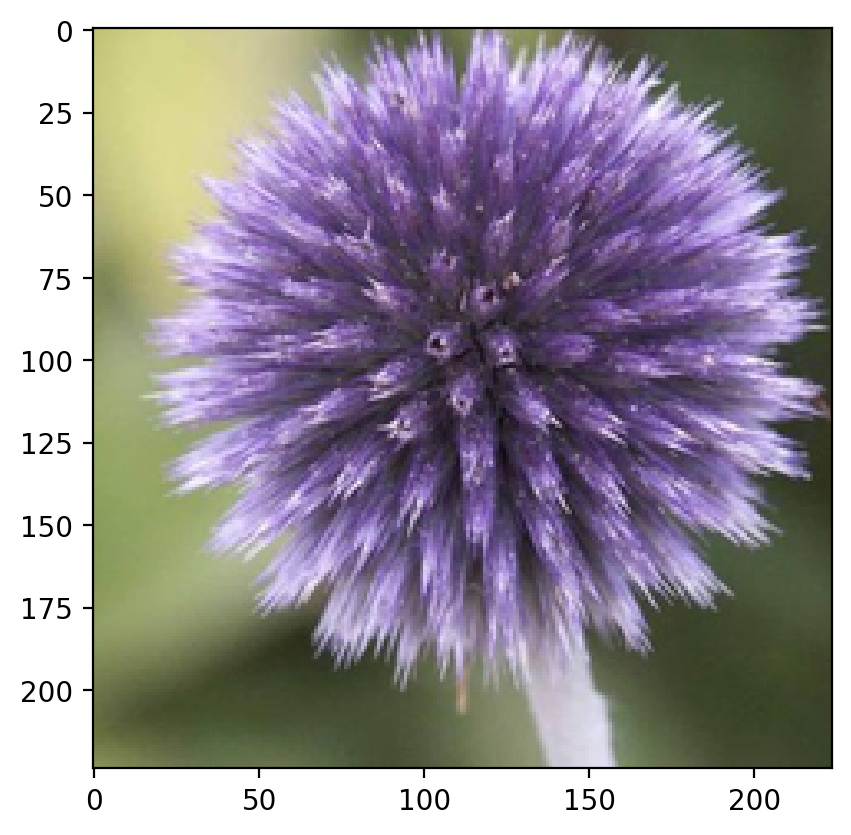

In [26]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = np.array (image)
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    #image = np.multiply (std, image) + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)

    ax.imshow(image)

    return ax

image_path = '/content/flower_data/train/10/image_07086.jpg'
img = process_image(image_path)
#img.shape
imshow(img)
#(np.array([0.229, 0.224, 0.225])).shape
#img = img.transpose ((1,2,0))
#img

In [27]:
#mapping = train_image_datasets.class_to_idx

#indeces = np.array ([1, 10, 100, 101, 102])
#classes = pd.DataFrame ([mapping [item] for item in indeces]) #replacing indeces with classes
#classes = np.array (classes) #converting to Numpy array

def predict(image_path, model, topkl):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file
    image = process_image (image_path) #loading image and processing it using above defined function

    #we cannot pass image to model.forward 'as is' as it is expecting tensor, not numpy array
    #converting to tensor
    im = torch.from_numpy (image).type (torch.FloatTensor)

    im = im.unsqueeze (dim = 0) #used to make size of torch as expected. as forward method is working with batches,
    #doing that we will have batch size = 1

    with torch.no_grad ():
        output = model.forward (im)
    output_prob = torch.exp (output) #converting into a probability

    probs, indeces = output_prob.topk (topkl)
    probs = probs.numpy () #converting both to numpy array
    indeces = indeces.numpy ()

    probs = probs.tolist () [0] #converting both to list
    indeces = indeces.tolist () [0]


    mapping = {val: key for key, val in
                model.class_to_idx.items()
                }

    classes = [mapping [item] for item in indeces]
    #classes = pd.DataFrame ([mapping [item] for item in indeces]) #replacing indeces with classes
    classes = np.array (classes) #converting to Numpy array

    return probs, classes

<ipython-input-24-b4af56b37dbb>:12: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail ((50000, height), Image.ANTIALIAS)


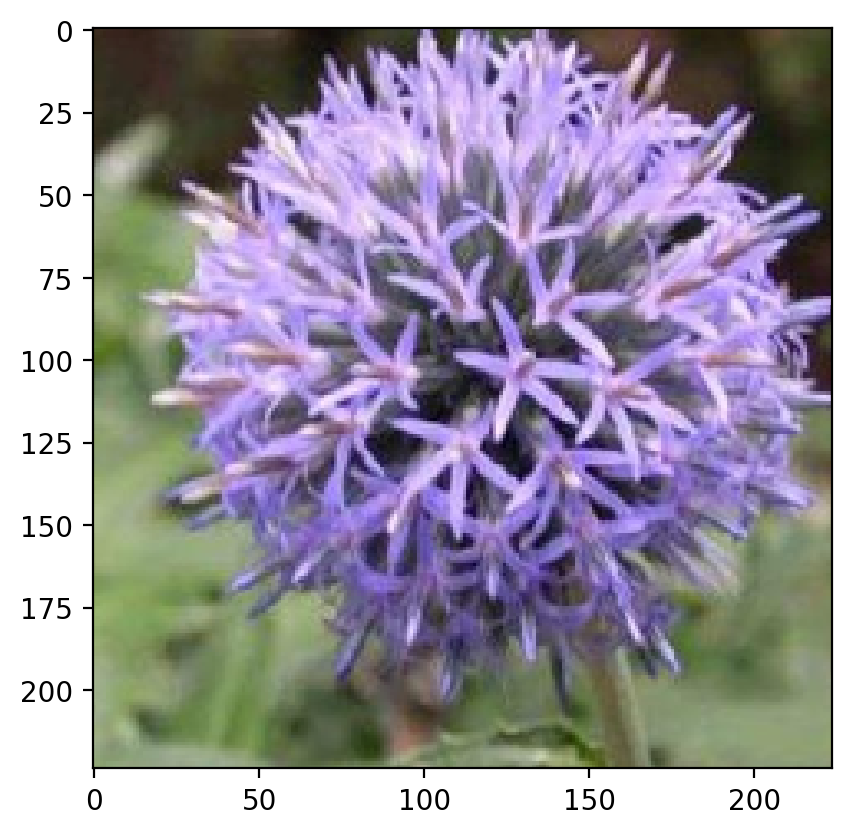

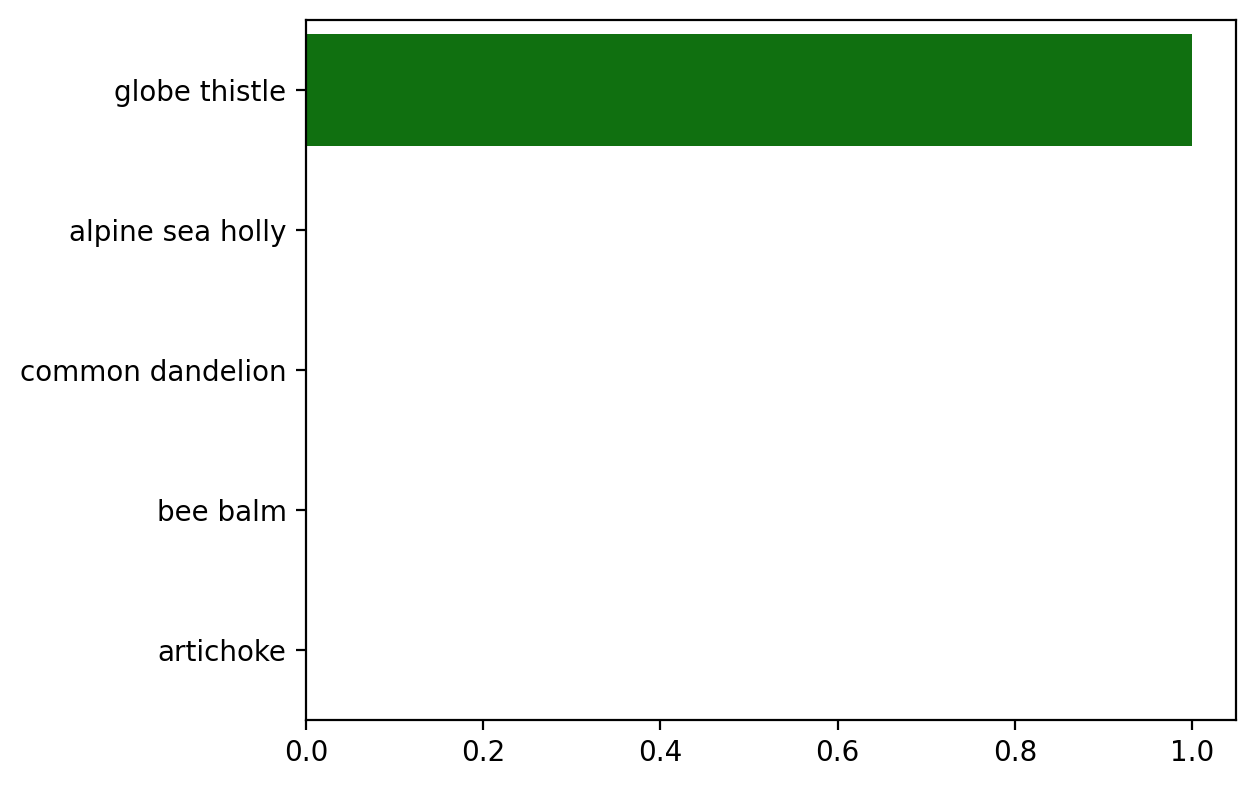

In [30]:
## TODO: Display an image along with the top 5 classes
#model = model_verify #using the restored one
file_path = '/content/flower_data/valid/10/image_07094.jpg' #an example from test set

img = process_image (file_path)
imshow (img)
plt.show()
probs, classes = predict (file_path, model, 5)

#print (probs)
#print (classes)

#preparing class_names using mapping with cat_to_name

class_names = [cat_to_name [item] for item in classes]

#fig, (ax2) = plt.subplots(figsize=(6,9), ncols=2)
plt.figure(figsize = (6,10))
plt.subplot(2,1,2)
#ax2.barh(class_names, probs)
#ax2.set_aspect(0.1)
#ax2.set_yticks(classes)
#ax2.set_title('Flower Class Probability')
#ax2.set_xlim(0, 1.1)

sns.barplot(x=probs, y=class_names, color= 'green');

#width = 1/5
#plt.subplot(2,1,2)
#plt.bar (classes, probs, width, color = 'blue')
plt.show()